# Chapter 6

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import hvplot.pandas

from tqdm.notebook import tqdm_notebook

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

%matplotlib inline

## Lab

### Best Subset Selection

In [3]:
hitters = pd.read_csv('../data/hitters.csv', index_col=0)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [10]:
# No. nans
hitters.isna().any(axis=1).sum()

0

In [6]:
hitters.dropna(inplace=True)

In [14]:
X = hitters.drop('Salary', axis=1)
y = hitters.Salary

X = pd.get_dummies(X, drop_first=False, columns=X.select_dtypes('object').columns)
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CWalks,PutOuts,Assists,Errors,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,...,375,632,43,10,0,1,0,1,0,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,...,263,880,82,14,1,0,0,1,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,...,354,200,11,3,0,1,1,0,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,...,33,805,40,4,0,1,1,0,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,...,194,282,421,25,1,0,0,1,1,0


In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools


def eval_model(features):
    """
    Train a Linear Regression 
    model using the features
    and return the RMSE on the training set
    """
    model = LinearRegression()
    model.fit(X[features], y)
    return np.sqrt(mean_squared_error(y, model.predict(X[features])))

def best_subset_selection(k=8):
    
    results = []
    for features in tqdm_notebook(itertools.combinations(X.columns, k)):
        features = list(features)
        results.append({
            'rmse': eval_model(features),
            'features': features
        })
        
    results = pd.DataFrame(results).sort_values(by='rmse')
    
    best_features, best_score = results.iloc[0].values
        
    return best_features, best_score

In [45]:
best_features, best_score = best_subset_selection(k=4)

print('Found best subset to be {:.2f}, with RMSE of\n{}'.format(best_features, best_score))


Found best subset to be 326.12, with RMSE of
['Hits', 'CRBI', 'PutOuts', 'Division_W']


### Forward Stepwise Selection

In [57]:
def rss(y, yhat):
    return sum((y-yhat)**2)

def stepwise_forward_selection(model, X, y, maximize=True):
    """
    Stepwise forward selection on linear model
    using BIC, 
    """
    
    features = X.columns.tolist()
    
    selected_features = []
    stepwise_scores = []
    for k in tqdm_notebook(range(len(features))):
        scores = []
        for j in range(len(features)):
            
            X_curr = X[selected_features + [features[j]]]
            
            model.fit(X_curr, y)
            
            preds = model.predict(X_curr)
            scores.append(rss(y, preds))
            
        # select feature with best additional score
        if maximize:
            best_feat, best_score = features[np.argmax(scores)], np.max(scores)
        else:
            best_feat, best_score = features[np.argmin(scores)], np.min(scores)
            
            
        # Remove from pool
        features.remove(best_feat)
        
        selected_features.append(best_feat)
        stepwise_scores.append(best_score)
        
    # Number of samples
    n = X.shape[0]

    # Calculate BIC & Cp
    scores_df = pd.DataFrame(stepwise_scores, columns=['RSS'])

    features_nested = []
    for f in selected_features:
        features_nested.append(features_nested+[f])

    # Error variance
    sigma_est = scores_df['RSS'].min() / (n - scores_df.shape[1] - 1)

    scores_df['features'] = features_nested

    scores_df['num_features'] = scores_df.index

    scores_df['Cp'] = (1/n) * (scores_df['RSS'] + 2*scores_df['num_features'] * sigma_est)

    scores_df['BIC'] = (1/(sigma_est*n)) * (scores_df['RSS'] + np.log(n)*scores_df['num_features'] * sigma_est)

    
    return scores_df

In [60]:
scores_df = stepwise_forward_selection(LinearRegression(), X, y, maximize=False)

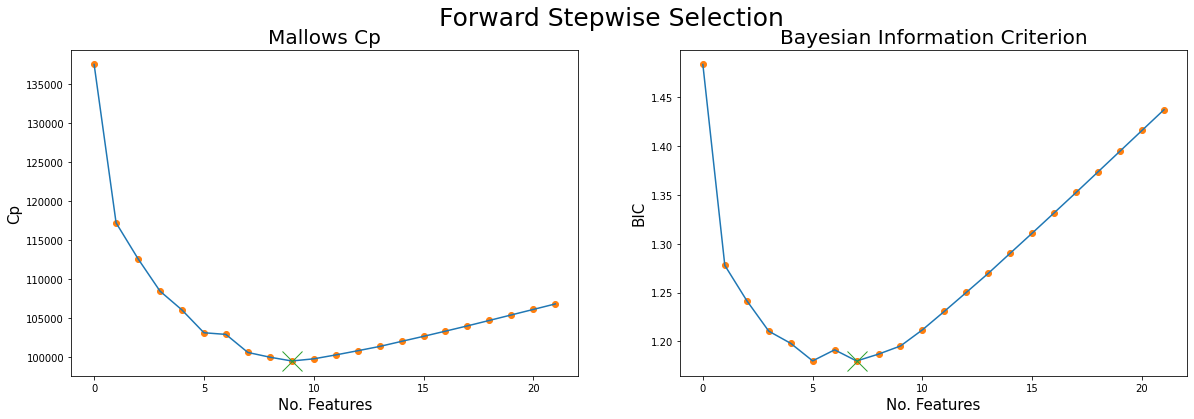

In [65]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

ax = axes[0]
metric = 'Cp'
min_idx, min_val = scores_df[metric].idxmin(), scores_df[metric].min()
ax.plot(scores_df['num_features'], scores_df[metric], color=colors[0])
ax.scatter(scores_df['num_features'], scores_df[metric], color=colors[1])
ax.plot(min_idx, min_val, color=colors[2], marker='x', markersize=20)
ax.set_title('Mallows Cp', fontsize=20)
ax.set_xlabel('No. Features', fontsize=15)
ax.set_ylabel(metric, fontsize=15)


ax = axes[1]
metric = 'BIC'
min_idx, min_val = scores_df[metric].idxmin(), scores_df[metric].min()
ax.plot(scores_df['num_features'], scores_df[metric], color=colors[0])
ax.scatter(scores_df['num_features'], scores_df[metric], color=colors[1])
ax.plot(min_idx, min_val, color=colors[2], marker='x', markersize=20)
ax.set_title('Bayesian Information Criterion', fontsize=20)
ax.set_xlabel('No. Features', fontsize=15)
ax.set_ylabel(metric, fontsize=15)


fig.suptitle('Forward Stepwise Selection', fontsize=25);

_...skipping the rest of the lab and exercises for now._